## Imports

In [3]:
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.datasets import cifar10  #
from keras.models import Sequential  # Model type to be used
from keras.layers import Dense, Conv2D, Flatten
import keras.utils as np_utils
import tensorflow as tf
from manifold_angles import ManifoldAngles

## Define classes and functions

In [4]:
def shuffle_data(X: np.ndarray, Y: np.ndarray, seed: int):
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(Y)

In [5]:
def get_reduced_datasets(data_size: int, X: np.ndarray, Y: np.ndarray, order_method: str, curvature_set='input', dataset='mnist'):

  _input_curvatures = input_class_curvatures
  _output_curvatures = output_class_curvatures
  _train_y = train_y

  _curvature_set = _input_curvatures if curvature_set == 'input' else _output_curvatures

  for y_class in range(10):
    class_indices = _train_y == y_class
    keep_indices = None
    if order_method == 'random':
      keep_indices = np.random.choice(X[class_indices].shape[0], data_size, replace=True)
    elif order_method == 'low_to_high':
      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[:data_size]
    elif order_method == 'high_to_low':
      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[-data_size:]
    elif order_method == 'extremes':
      return get_reduced_datasets_extremes(data_size, X, Y, curvature_set)
    elif order_method == 'mid':
      num_low_curv = data_size // 2
      num_high_curv = data_size - num_low_curv

      curv_midpoint = _curvature_set[y_class][:, 0].shape[0] // 2

      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[curv_midpoint - num_low_curv : curv_midpoint + num_high_curv]
    elif order_method == 'ratio_low_to_high':
      ratios = _output_curvatures[y_class][:, 0] / _input_curvatures[y_class][:, 0]
      keep_indices = np.argsort(ratios)[:data_size]
    elif order_method == 'ratio_high_to_low':
      ratios = _output_curvatures[y_class][:, 0] / _input_curvatures[y_class][:, 0]
      keep_indices = np.argsort(ratios)[-data_size:]
    else:
      raise ValueError(f"order method not implemented: {order_method}")

    new_x_row = X[class_indices][keep_indices]
    new_y_row = Y[class_indices][keep_indices]

    Reduced_X = np.vstack([Reduced_X, new_x_row]) if y_class > 0 else new_x_row
    Reduced_Y = np.vstack([Reduced_Y, new_y_row]) if y_class > 0 else new_y_row

  return Reduced_X, Reduced_Y

def get_reduced_datasets_extremes(data_size: int, X: np.ndarray, Y: np.ndarray, curvature_set='input'):
  _curvature_set = input_class_curvatures if curvature_set == 'input' else output_class_curvatures
  num_low_curv = data_size // 2
  num_high_curv = data_size - num_low_curv
  for y_class in range(10):
    class_indices = train_y == y_class
    argsorted_curvatures = np.argsort(_curvature_set[y_class][:, 0])
    low_curv_indices = argsorted_curvatures[:num_low_curv]
    high_curv_indices = argsorted_curvatures[-num_high_curv:]

    new_x_rows = np.vstack([X[class_indices][low_curv_indices], X[class_indices][high_curv_indices]])
    new_y_rows = np.vstack([Y[class_indices][low_curv_indices], Y[class_indices][high_curv_indices]])

    Reduced_X = np.vstack([Reduced_X, new_x_rows]) if y_class > 0 else new_x_rows
    Reduced_Y = np.vstack([Reduced_Y, new_y_rows]) if y_class > 0 else new_y_rows

  return Reduced_X, Reduced_Y

In [6]:
def get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', curvature_set='input', num_models=5, shuffle_seed=None, dataset='mnist'):
  valacclist = []
  acclist = []
  for data_size in datasizes:
    Reduced_X_train, Reduced_Y_train = get_reduced_datasets(data_size, X_train, Y_train, order_method, curvature_set, dataset=dataset)
    print(f'ReducedX.shape: {Reduced_X_train.shape}')

    if shuffle_seed is not None:
      shuffle_data(Reduced_X_train, Reduced_Y_train, shuffle_seed)

    valacclist.append([])
    acclist.append([])
    for _ in range(num_models):
      nt = create_model()
      nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
      history = nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size = 128)
      del nt
      print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
      valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
      acclist[-1].append(history.history['categorical_accuracy'][-1])
      del history

  return valacclist, acclist

In [7]:
def plot_accuracies(accuracies, names=None):
  plt.figure(figsize=(14, 10))
  for acclist in accuracies:
    plt.plot(datasizes, np.mean(acclist, axis=1))

  if names is not None:
    plt.legend(names, fontsize=11)

  plt.xscale('log')
  plt.gca().invert_xaxis()
  plt.grid()
  plt.show()

## Mnist

In [8]:
def create_model():
  model = Sequential()
  model.add(Conv2D(50, kernel_size=(28,28), input_shape=(28,28,1), activation='PReLU',use_bias=False, kernel_initializer='random_uniform',padding='valid'))
  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  model.add(Dense(10, activation='softmax', kernel_initializer= 'random_uniform'))

  return model

In [9]:
(X_train, train_y), (X_test, test_y) = mnist.load_data()

X_train = X_train / 255
X_test = X_test/ 255

Y_train = np_utils.to_categorical(train_y, 10)
Y_test = np_utils.to_categorical(test_y, 10)

# indices = np.random.choice(X_train[train_y==0].shape[0],10000,replace=True)
# s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==0][indices]))
# print(np.sum(np.cumsum(s ** 2) / np.sum(s ** 2) < 0.99))

# nt = create_model()
# nt.summary()
# nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
# history  = nt.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=1, batch_size = 128)
# print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")


11490434/11490434 [==============================] - 0s 0us/step


In [10]:
# input_class_curvatures = []
# define curvatures list
# for y_class in range(10):
  # lowersize = 50
  # s,u,v = tf.linalg.svd(tf.keras.layers.Flatten()(X_train[train_y==y_class]))
  # layerdata = (u[:,:lowersize]*s[:lowersize]).numpy()
  # tf.print('layer quality: ', tf.norm(s[:lowersize]) / tf.norm(s))
  # del s,u,v

  # layerfeatlist = [layerdata]
  # results, manifold_neighbour_angle_sum =  ManifoldAngles(layerfeatlist, classsize= 1,neighboursize1=10 ,dim_reduc_size=5)

  # input_class_curvatures.append(np.array(manifold_neighbour_angle_sum))
with open('mnist_input_curv', 'rb') as file:
  input_class_curvatures = pickle.load(file)

In [11]:
# Y_predicted = nt.predict(X_train)
# define curvatures list
# output_class_curvatures = []
# for y_class in range(10):
  # layerfeatlist = [Y_predicted[train_y == y_class]]
  # results, manifold_neighbour_angle_sum = ManifoldAngles(layerfeatlist, classsize=1, neighboursize1=10, dim_reduc_size=5)
  # output_class_curvatures.append(np.array(manifold_neighbour_angle_sum))
with open('mnist_output_curv', 'rb') as file:
  output_class_curvatures = pickle.load(file)

In [12]:
datasizes = np.logspace(3.699, 2.599, 20).astype('int')

In [ ]:
random_val_acc, random_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='random')

In [ ]:
input_based_low_val_acc, input_based_low_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', shuffle_seed=1337)

In [ ]:
output_based_low_val_acc, output_based_low_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', curvature_set='output', shuffle_seed=1337)

In [ ]:
input_based_high_val_acc, input_based_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='high_to_low', shuffle_seed=1337)

In [ ]:
output_based_high_val_acc, output_based_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='high_to_low', curvature_set='output', shuffle_seed=1337)

In [ ]:
input_based_low_high_val_acc, input_based_low_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='extremes', shuffle_seed=1337)

In [ ]:
output_based_low_high_val_acc, output_based_low_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='extremes', curvature_set='output', shuffle_seed=1337)

In [ ]:
input_based_mid_val_acc, input_based_mid_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='mid', shuffle_seed=1337)

In [ ]:
output_based_mid_val_acc, output_based_mid_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='mid', curvature_set='output', shuffle_seed=1337)

In [18]:
methods = ['high', 'low', 'low_high', 'mid']
curv_types = ['in', 'out']
accuracies = []
for method in methods:
  for curv_type in curv_types:
    with open(f'mnist_{curv_type}_{method}_acc', 'rb') as file:
      accuracies.append(pickle.load(file))

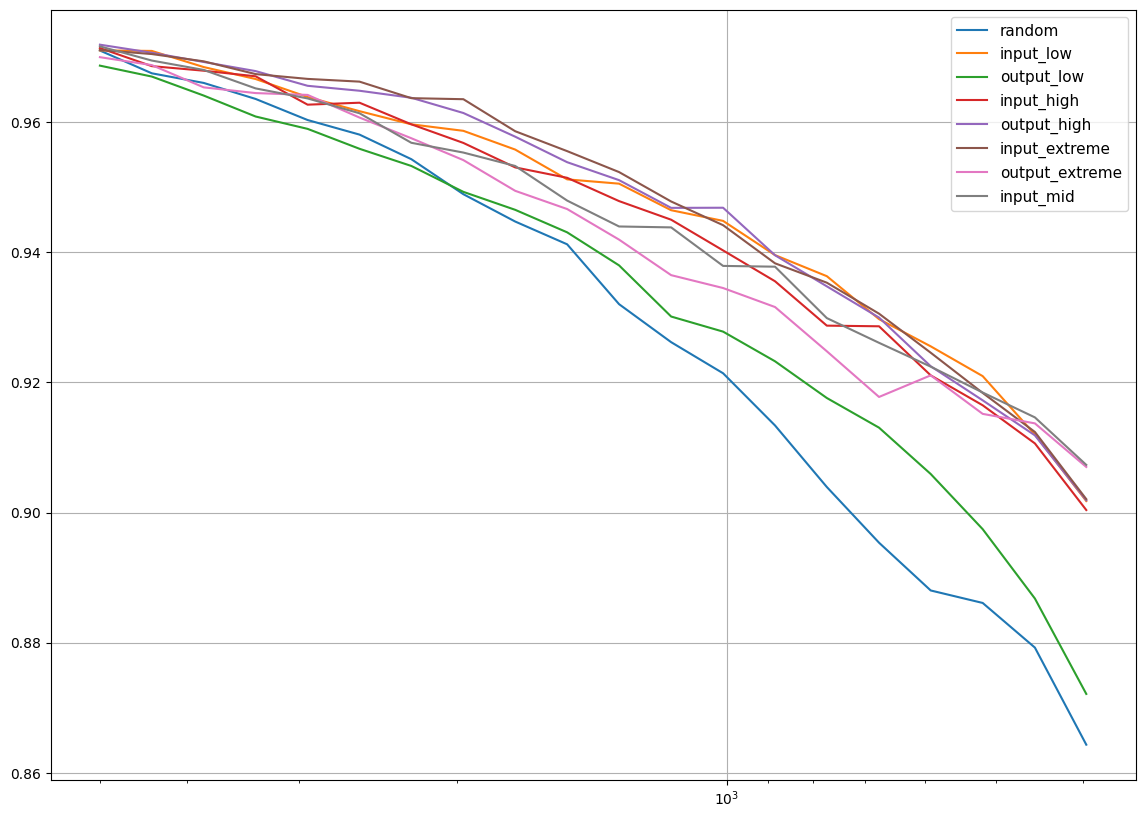

In [19]:
names = ['random', 'input_low', 'output_low', 'input_high', 'output_high', 'input_extreme', 'output_extreme', 'input_mid', 'output_mid']
plot_accuracies(accuracies, names)